In [2]:
#! cp /content/drive/MyDrive/mnist_sg_cnn/utils.py .
import utils
#! cp /content/drive/MyDrive/mnist_sg_cnn/snn_utils.py .
import snn_utils

#! cp /content/drive/MyDrive/mnist_sg_cnn/base_model.py .

import base_model

#! cp /content/drive/MyDrive/mnist_sg_cnn/lenet_decolle_model.py .

import lenet_decolle_model

In [22]:
import torch
import pylab as plt
device = 'cpu'

gen_train = snn_utils.get_mnist_loader(100, Nparts=100, train=True)
gen_test = snn_utils.get_mnist_loader(100, Nparts=100, train=False)

def iter_mnist(gen_train, batchsize=100, T=1000, max_rate = 20):
    datait = iter(gen_train)
    for raw_input, raw_labels in datait:
        data, labels1h = snn_utils.image2spiketrain(raw_input, raw_labels, max_duration=T, gain=max_rate) # converting data into spikes
        data_t = torch.FloatTensor(data)
        labels_t = torch.Tensor(labels1h)
        yield data_t, labels_t

T = 4 #duration of sequence
data, target = next(iter_mnist(gen_train, T=T))

def decolle_loss(r, s, tgt):
    loss_tv = 0
    for i in range(len(r)):
        print(r[i].shape)
        print(tgt.shape)
        loss_tv += loss(r[i],tgt) 
    return loss_tv

loss = torch.nn.SmoothL1Loss()

convnet_sg = lenet_decolle_model.LenetDECOLLE( out_channels=10,
                    Nhid=[16,32], #Number of convolution channels
                    Mhid=[64],
                    kernel_size=[7],
                    pool_size=[2,2],
                    input_shape=data.shape[2:],
                    alpha=[.95],
                    alpharp=[.65],
                    beta=[.92],
                    num_conv_layers=2,
                    num_mlp_layers=1,
                    lc_ampl=.5).to(device)

convnet_sg

data_d = data.to(device)
target_d = target.to(device)
convnet_sg.init_parameters(data_d.transpose(0,1))

In [10]:
data.shape[2:]

torch.Size([1, 28, 28])

In [20]:
data_d.shape

torch.Size([4, 100, 1, 28, 28])

In [19]:
data_d.transpose(0,1).shape

torch.Size([100, 4, 1, 28, 28])

In [11]:
output = convnet_sg(data)
(output.argmax(axis=1)).data.cpu().numpy()

AttributeError: 'tuple' object has no attribute 'argmax'

In [12]:
output[0][0].shape

torch.Size([100, 16, 14, 14])

In [23]:
opt_conv = torch.optim.Adamax(convnet_sg.get_trainable_parameters(), lr=1e-9, betas=[0., .95])
for e in range(5):        
    error = []
    accuracy=[]
    for data, label in iter_mnist(gen_train, T=T):
        convnet_sg.train()
        loss_hist = 0
        data_d = data.to(device)
        label_d = label.to(device)
        convnet_sg.init(data_d.transpose(0,1), burnin=10)
        readout = 0

        #print(label_d[-1])
        #print(label_d[-1].shape)
        #break
        
        for n in range(T):
            print(f"Data shape: {data_d[n].shape}")
            st, rt, ut = convnet_sg.forward(data_d[n])
            print("Readout")
            print(len(rt), rt[0].shape, rt[1].shape, rt[2].shape)
            print("Label")
            print(label_d[n].shape)
            loss_tv = decolle_loss(rt, st, label_d[n])
            break
            loss_tv.backward()
            opt_conv.step()
            opt_conv.zero_grad()
            loss_hist += loss_tv
            readout += rt[-1]
        error += (readout.argmax(axis=1)!=label_d[-1].argmax(axis=1)).float()
        accuracy+=(readout.argmax(axis=1)==label_d[-1].argmax(axis=1)).float()
    print('Training Error', torch.mean(torch.Tensor(error)).data)
    print('Training accuracy', torch.mean(torch.Tensor(accuracy)).data)     
    print('Epoch', e, 'Loss', loss_hist.data)
    PATH = '/content/drive/MyDrive/mnist_sg/mnist_network_sg_conv.pth'
    torch.save(convnet_sg.state_dict(), PATH)

Data shape: torch.Size([100, 1, 28, 28])
Readout
3 torch.Size([100, 10]) torch.Size([100, 10]) torch.Size([100, 10])
Label
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])


AttributeError: 'int' object has no attribute 'argmax'

In [ ]:
PATH = '/content/drive/MyDrive/mnist_sg/mnist_network_sg_conv.pth'
convnet_sg.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
#from resources.plotcm import plot_confusion_matrix

import numpy

error = []
accuracy=[]
y_pred = []
y_true = []


for data, label in iter_mnist(gen_test, T=T):
        loss_hist = 0
        data_d = data.to(device)
        label_d = label.to(device)
        convnet_sg.init(data_d.transpose(0,1), burnin=100)
        readout = 0
        with torch.no_grad():
          for n in range(T):
             st, rt, ut=convnet_sg.forward(data_d[n])
             loss_tv = decolle_loss(rt, st, label_d[n])
             
             loss_hist += loss_tv
             readout += rt[-1]
          output = (readout.argmax(axis=1)).data.cpu().numpy()
          y_pred.extend(output)
          labels =(label_d[-1].argmax(axis=1)).data.cpu().numpy()
          y_true.extend(labels)
          accuracy+=(readout.argmax(axis=1)==label_d[-1].argmax(axis=1)).float()
          error += (readout.argmax(axis=1)!=label_d[-1].argmax(axis=1)).float()
print('Testing Error', torch.mean(torch.Tensor(error)).data)
print('Testing accuracy', torch.mean(torch.Tensor(accuracy)).data)
accuracy=torch.mean(torch.Tensor(accuracy)).item()
# Build confusion matrix
classes = ('O', '1', '2', '3', '4',
        '5', '6', '7', '8', '9')
cm = confusion_matrix(y_true, y_pred)



cm

Testing Error tensor(0.0151)
Testing accuracy tensor(0.9849)


array([[ 974,    0,    1,    0,    1,    1,    2,    1,    0,    0],
       [   0, 1126,    2,    1,    0,    0,    3,    0,    3,    0],
       [   4,    0, 1018,    1,    1,    0,    0,    6,    2,    0],
       [   0,    0,    1,  997,    0,    3,    0,    6,    3,    0],
       [   0,    0,    1,    0,  965,    0,    4,    1,    2,    9],
       [   2,    0,    0,    7,    0,  877,    3,    1,    1,    1],
       [   5,    3,    0,    0,    2,    2,  945,    0,    1,    0],
       [   0,    2,    7,    0,    3,    0,    0, 1012,    1,    3],
       [   4,    0,    2,    5,    3,    1,    1,    2,  952,    4],
       [   4,    3,    0,    5,    6,    2,    0,    5,    1,  983]])

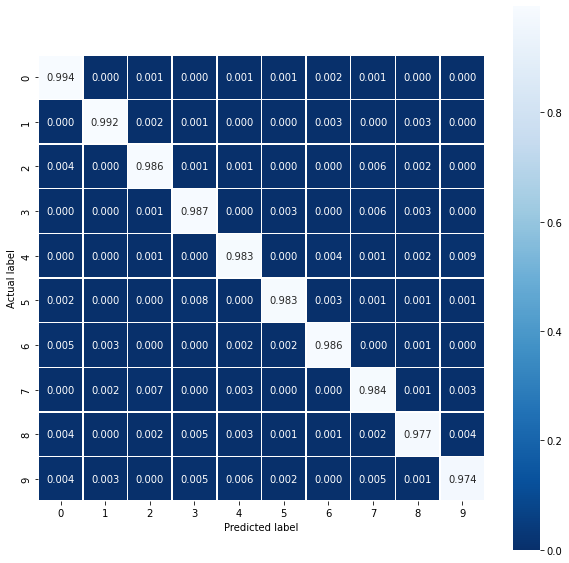

In [ ]:
# Used for Confusion Matrix
from sklearn import metrics
import seaborn as sns
import numpy as np
cm = metrics.confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]



plt.figure(figsize=(10,10))
sns.heatmap(cm_normalized, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
#all_sample_title = 'Accuracy = {} %'.format(np.accuracy)*100 
#plt.title(all_sample_title, size = 5);
plt.savefig('/content/drive/MyDrive/mnist_sg/confusion_matrix_20epoch_conv.svg')